# Differential Expression and Gene Ontology Analysis of Genes Related to Inborn Errors of Immunity in Cancer

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.stats import combine_pvalues

## Constants

In [2]:
FC_CUT = 1
P_CUT = 0.05

## Global Functions

In [3]:
def fisher_method_threshold(p_values, min_p_value = 1e-16):
    p_values = np.maximum(p_values, min_p_value)
    _, combined_p_value = combine_pvalues(p_values, method='fisher')
    return combined_p_value

## Loading in Differential Expression Results

In [11]:
#establish file paths to DEA results
proj_codes_df = pd.read_csv('proj_codes.csv')
proj_codes_df['matched_tissue'] = proj_codes_df['matched_tissue'].str.replace(' ','_')

results_dir = '*ENTER DIRECTORY WITH R OUTPUT HERE*'

sample_counts = pd.read_csv(os.path.join(results_dir, 'samples.Count.csv'))

IEI_genes = pd.read_csv('IEI_genes.csv')

file_paths_DEA = proj_codes_df.apply(
    lambda row: os.path.join(results_dir, row['proj'], 'DEA', f"all_DEGs_{row['proj']}_{row['sample_abbr']}_GTEX_{row['matched_tissue']}.csv"),
    axis = 1
)

file_paths_subset_DEA = proj_codes_df.apply(
    lambda row: os.path.join(results_dir, row['proj'], 'DEA', f"subset_DEGs_{row['proj']}_{row['sample_abbr']}_GTEX_{row['matched_tissue']}.csv"),
    axis = 1
)

projects = proj_codes_df.apply(lambda row: f"{row['proj']} vs. {row['matched_tissue']}", axis=1).tolist()

#load data from specified files into pandas dataframes
DEA_dfs = []
subset_DEA_dfs = []

for i, file_path in enumerate(file_paths_DEA):
    df = pd.read_csv(file_path)
    df['proj'] = proj_codes_df.iloc[i]['proj']
    DEA_dfs.append(df)

for i, file_path in enumerate(file_paths_subset_DEA):
    df = pd.read_csv(file_path)
    df['proj'] = proj_codes_df.iloc[i]['proj']
    subset_DEA_dfs.append(df)

## Calculation of Odds Ratios and 95% Confidence Intervals ***For Each*** Cancer Type Examined

In [12]:
odds_ratios = []
ci_lowers = []
ci_uppers = []

for i in range(len(DEA_dfs)):
    total_df = DEA_dfs[i]
    subset_df = subset_DEA_dfs[i]

    total_genes = sample_counts.iloc[i, 3]
    deg_total_genes = len(total_df[((total_df['logFC'] > FC_CUT) | (total_df['logFC'] < -FC_CUT)) & (total_df['adj.P.Val'] < P_CUT)])
    subset_genes = len(IEI_genes)
    deg_subset_genes = len(subset_df[((subset_df['logFC'] > FC_CUT) | (subset_df['logFC'] < -FC_CUT)) & (subset_df['adj.P.Val'] < P_CUT)])

    genes_not_in_subset = total_genes - subset_genes
    deg_genes_not_in_subset = deg_total_genes - deg_subset_genes

    #calculate odds ratio
    odds_ratio = (deg_subset_genes / subset_genes) / (deg_genes_not_in_subset / genes_not_in_subset)
    odds_ratios.append(odds_ratio)

    #calculate standard error of log(odds_ratio)
    se_log_or = np.sqrt(
        (1 / deg_subset_genes) +
        (1 / (subset_genes - deg_subset_genes)) + 
        (1 / deg_genes_not_in_subset) +
        (1 / (genes_not_in_subset - deg_genes_not_in_subset))
    )

    #calculate confidence interval
    log_or = np.log(odds_ratio)
    ci_lower = np.exp(log_or - 1.96 * se_log_or)
    ci_upper = np.exp(log_or + 1.96 * se_log_or)

    ci_lowers.append(ci_lower)
    ci_uppers.append(ci_upper)

## Plotting Odds Ratios

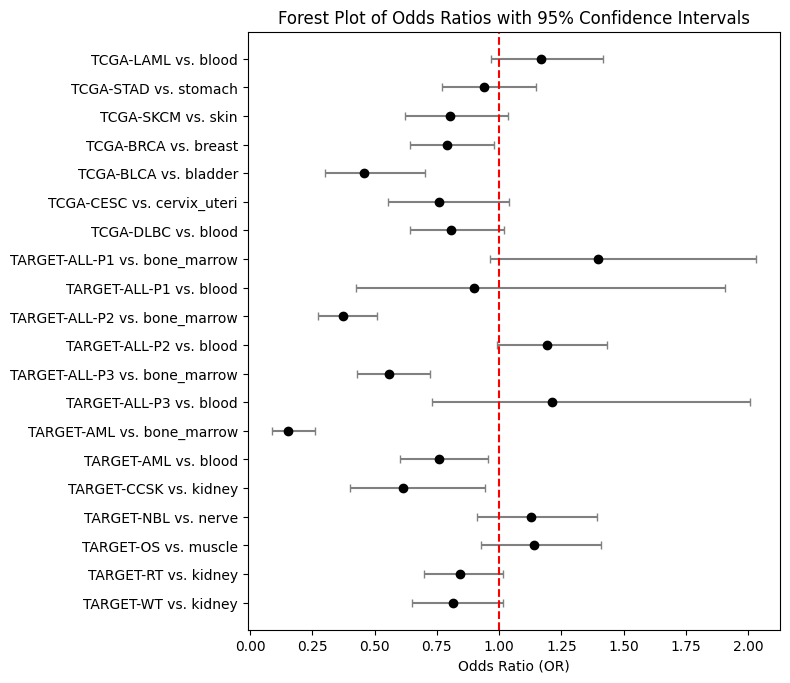

In [15]:
data = {
    'Project': projects,
    'OR': odds_ratios,
    'CI Lower': ci_lowers,
    'CI Upper': ci_uppers
}

plot_df = pd.DataFrame(data)

# number of variables
n_vars = len(df)

#create figure + axis
fig, ax = plt.subplots(figsize = (8, n_vars * 0.0125))

#plot ORs with CIs
ax.errorbar(plot_df['OR'], 
    plot_df.index, 
    xerr=[plot_df['OR'] - plot_df['CI Lower'], 
    plot_df['CI Upper'] - plot_df['OR']],
    fmt = 'o',
    color = 'black',
    ecolor = 'gray',
    capsize = 3)

#add vertical line for OR = 1 (null hypothesis)
ax.axvline(x = 1, color = 'red', linestyle = '--')

#set labels
ax.set_yticks(plot_df.index)
ax.set_yticklabels(plot_df['Project'])

ax.set_xlabel('Odds Ratio (OR)')
ax.set_title('Forest Plot of Odds Ratios with 95% Confidence Intervals')

#invert y-axis to have first variable on top
ax.invert_yaxis()

#show plot
plt.savefig('ForestPlot.png', dpi = 600, bbox_inches = 'tight')
plot_df.to_csv('odds_ratios.csv', index = False)

plt.tight_layout()
plt.show()

## Differentially Expressed Genes ***Across All*** Cancers

In [17]:
#concatenate all DEA dataframes into single respective dataframe
DEA_data = pd.concat(subset_DEA_dfs, ignore_index = True)

#count occurences of each gene
gene_counts = DEA_data['Gene.symbol'].value_counts().reset_index()
gene_counts.columns = ['Gene.symbol', 'count']

#calculate the fisher combined p-vals and log2fc for each gene
grouped_DEA_data = DEA_data.groupby('Gene.symbol').agg(
    combined_p_values = ('adj.P.Val', lambda p_values: fisher_method_threshold(p_values)),
    average_log2fc = ('logFC', 'mean')
).reset_index()

#aggregate project codes for each gene
project_codes = DEA_data.groupby('Gene.symbol')['proj'].apply(lambda x: list(x.unique())).reset_index()

#merge gene counts with grouped data
DEA_result_df = pd.merge(gene_counts, grouped_DEA_data, on='Gene.symbol')
DEA_result_df = pd.merge(DEA_result_df, project_codes, on='Gene.symbol')

#Filter to get significant top up/down regulated terms
top_upregulated = DEA_result_df[DEA_result_df['average_log2fc'] > FC_CUT].sort_values(by = 'average_log2fc', ascending = False)
top_downregulated = DEA_result_df[DEA_result_df['average_log2fc'] < -FC_CUT].sort_values(by = 'average_log2fc', ascending = True)

#Sort by count
most_deregulated = DEA_result_df[abs(DEA_result_df['average_log2fc']) > FC_CUT].sort_values(by = 'count', ascending = False)

In [18]:
top_upregulated.to_csv('top_upregulated.csv', index = False)
top_downregulated.to_csv('top_downregulated.csv', index = False)

most_deregulated.to_csv('most_deregulated.csv', index = False)

In [217]:
DEGs = DEA_result_df.drop(axis = 'columns', labels = ['count', 'proj'])
DEGs.to_csv('all_IEI_DEGs.csv', index = False)